# Chapter 6 The Haunted DAG & The Casual Terror

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy import stats
from scipy.optimize import curve_fit

warnings.simplefilter(action="ignore", category=FutureWarning)

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
np.random.seed(0)

# 6.0 问题引入

在现实生活中存在如下现象：似乎最有新闻价值的科学研究都是最不值得信赖的。话题越无聊，结果就越严格。这种被普遍认可的负相关关系是如何存在的呢？

这里有一个简单的模拟来说明这一点。假设一个拨款审查小组收到了200项研究提案。在这些建议中，可信度（严谨性、学术性、成功的合理性）和新闻价值（社会福利价值、公共利益）之间没有任何相关性。该小组同样权衡了可信度和新闻价值,然后他们根据综合得分对这些提案进行排名，并选择前10%的资金来源。如Code 6.1所示得到一个负相关关系，可实际上两者并没有显著的关系。  

这种现象被称为**Berkson’s paradox(selection-distortion effect)**

当我们简单地在回归中添加变量而没有一个清晰的因果模型时，可能会得到不正确的结果。

在本章中，我们将探讨三种不同的情况：**多重共线性、post-treatment bias和collider bias**。


#### Code 6.1

In [3]:
np.random.seed(3)
N = 200  # num grant proposals
p = 0.1  # proportion to select
# uncorrelated newsworthiness and trustworthiness
nw = np.random.normal(size=N)
tw = np.random.normal(size=N)
# select top 10% of combined scores
s = nw + tw  # total score
q = np.quantile(s, 1 - p)  # top 10% threshold
selected = s >= q
cor = np.corrcoef(tw[selected], nw[selected])
cor

array([[ 1.        , -0.74495204],
       [-0.74495204,  1.        ]])

Text(0, 0.5, 'trustworthiness')

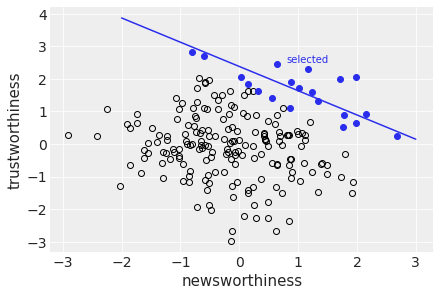

In [4]:
# Figure 6.1
plt.scatter(nw[~selected], tw[~selected], lw=1, edgecolor="k", color=(0, 0, 0, 0))
plt.scatter(nw[selected], tw[selected], color="C0")
plt.text(0.8, 2.5, "selected", color="C0")

# correlation line
xn = np.array([-2, 3])
plt.plot(xn, tw[selected].mean() + cor[0, 1] * (xn - nw[selected].mean()))

plt.xlabel("newsworthiness")
plt.ylabel("trustworthiness")

# 6.1 多重共线性

## 6.1.1 Multicollinear legs 用腿长预测身高

#### Code 6.2 模拟人的身高与左右腿长

In [5]:
N = 100  # number of individuals
height = np.random.normal(10, 2, N)  # sim total height of each
leg_prop = np.random.uniform(0.4, 0.5, N)  # leg as proportion of height
leg_left = leg_prop * height + np.random.normal(0, 0.02, N)  # sim left leg as proportion + error
leg_right = leg_prop * height + np.random.normal(0, 0.02, N)  # sim right leg as proportion + error

d = pd.DataFrame(
    np.vstack([height, leg_left, leg_right]).T,
    columns=["height", "leg_left", "leg_right"],
)  # combine into data frame

d.head()

,height,leg_left,leg_right
0,10.178107,4.206429,4.158048
1,11.557794,4.769875,4.825845
2,12.529290,5.543952,5.529080
3,8.238977,3.853735,3.801846
4,10.472811,4.333044,4.290579


分析数据：同时使用左腿和右腿两个预测因素来预测结果变量。平均而言，一个人的腿是他们身高的45%（在这些模拟数据中）。因此，我们应该期望测量一条腿与身高之间的关系的beta系数最终在平均身高（10）附近除以平均身高的45%（4.5）。**即10/4.5≈2.2。**

#### Code 6.3 计算后验分布

In [6]:
with pm.Model() as m_6_1:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)
    br = pm.Normal("br", 2, 10)

    mu = a + bl * d["leg_left"].values + br * d["leg_right"].values
    sigma = pm.Exponential("sigma", 1)

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d["height"].values)

    m_6_1_trace = pm.sample(draws=100)
    idata_6_1 = az.extract_dataset(m_6_1_trace)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, br, sigma]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 139 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


In [7]:
az.summary(m_6_1_trace, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.96,0.35,0.35,1.44,0.02,0.02,197.84,135.28,1.02
bl,-1.57,2.20,-4.55,2.18,0.19,0.13,135.70,127.56,1.03
br,3.59,2.19,-0.07,6.65,0.19,0.13,136.46,126.32,1.03
sigma,0.65,0.05,0.58,0.72,0.00,0.00,222.94,165.44,1.01


#### Code 6.4 画出各个参数89%的兼容区间

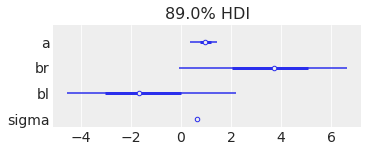

In [8]:
_ = az.plot_forest(m_6_1_trace, var_names=["a", "br", "bl", "sigma"], combined=True, figsize=[5, 2])

br与bl参数的兼容区间很大,可认为其不收敛，结果显然是有问题的。 回顾第五章的问题：Recall that a multiple linear regression answers the question: **What is the value of knowing each predictor, after already knowing all of the other predictors?** 
So in this case, **the question becomes: What is the value of knowing each leg’s length, after already knowing the other leg’s length?**

#### Code 6.5 & 6.6 画出br与bl的联合分布

Because we used MCMC (c.f. `quap`), the posterior samples are already in `m_6_1_trace`.

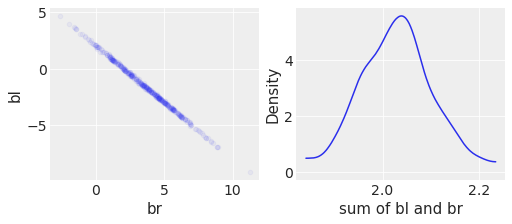

In [9]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[7, 3])

br_post = m_6_1_trace.posterior["br"].values
bl_post = m_6_1_trace.posterior["bl"].values

# code 6.5
ax1.scatter(br_post, bl_post, alpha=0.05, s=20)
ax1.set_xlabel("br")
ax1.set_ylabel("bl")

# code 6.6
az.plot_kde(br_post + bl_post, ax=ax2)
ax2.set_ylabel("Density")
ax2.set_xlabel("sum of bl and br");

发现br与bl几乎共线，当br很大时bl很小，且两者之和的分布服从正态。这是由于两个腿长变量包含几乎完全相同的信息。可以按以下步骤思考这个问题：  
- 假设模型为：
\begin{aligned}
y_{i} & \sim \operatorname{Normal}\left(\mu_{i}, \sigma\right) \\
\mu_{i} & =\alpha+\beta_{1} x_{i}+\beta_{2} x_{i}
\end{aligned}
- 实际模型为：
$$\mu_{i}=\alpha+\left(\beta_{1}+\beta_{2}\right) x_{i}$$  

这意味着后验分布最终报告了非常大范围的$\beta_1$和$\beta_2$组合，使它们的和接近于x和y的实际关系。从上图右图发现br+bl的分布的方差较小。

接下来仅以左脚作为预测变量计算后验，可得到相似的结果。

#### Code 6.7 仅将左脚作为预测变量计算后验

In [10]:
with pm.Model() as m_6_2:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)

    mu = a + bl * d.leg_left.values
    sigma = pm.Exponential("sigma", 1)

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height.values)

    m_6_2_trace = pm.sample()

az.summary(m_6_2_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.90,0.33,0.37,1.42,0.01,0.01,1516.91,1615.15,1.0
bl,2.04,0.07,1.93,2.16,0.00,0.00,1552.68,1741.55,1.0
sigma,0.66,0.05,0.58,0.73,0.00,0.00,1655.43,1633.22,1.0


## 6.1.2 Multicollinear milk 一些因果问题

In this example, we are concerned with the **perc.fat (percent fat)** and **perc.lactose (percent lactose)** variables. We’ll use these to model the **total energy content, kcal.per.g**. 

#### Code 6.8 数据标准化

In [11]:
d = pd.read_csv("Data/milk.csv", sep=";")


def standardise(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()


d.loc[:, "K"] = standardise(d["kcal.per.g"])
d.loc[:, "F"] = standardise(d["perc.fat"])
d.loc[:, "L"] = standardise(d["perc.lactose"])

d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,F,L
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-1.217243,1.307262
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.816126,-1.030355,1.011285
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.125913,-1.391531,1.382679
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.001998,-1.335535,1.586874
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.258511,-0.469693,0.257115


第五章指出，直接将变量加入多元回归中可能会**掩盖相关关系**。因此先进行二元回归。

#### Code 6.9 二元回归

In [12]:
# kcal.per.g regressed on perc.fat
with pm.Model() as m_6_3:
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)

    mu = a + bF * d.F.values
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K.values)

    m_6_3_trace = pm.sample()

az.summary(m_6_3_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.08,-0.13,0.14,0.0,0.0,4774.63,2707.69,1.0
bF,0.86,0.09,0.72,1.02,0.0,0.0,4182.05,2252.74,1.0
sigma,0.49,0.07,0.38,0.59,0.0,0.0,3808.33,2432.74,1.0


In [13]:
# kcal.per.g regressed on perc.lactose
with pm.Model() as m_6_4:
    a = pm.Normal("a", 0, 0.2)
    bL = pm.Normal("bF", 0, 0.5)

    mu = a + bL * d.L.values
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K.values)

    m_6_4_trace = pm.sample()

az.summary(m_6_4_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.07,-0.11,0.12,0.0,0.0,4706.19,2819.13,1.0
bF,-0.90,0.08,-1.02,-0.77,0.0,0.0,4656.63,3094.01,1.0
sigma,0.41,0.06,0.32,0.50,0.0,0.0,4001.47,2300.83,1.0


bF和bL的后验分布本质上是彼此的镜像。bF的后验均值为正，而bL的均值为负。两者均拥有狭窄的后验分布，几乎完全位于零的一边或另一边。

鉴于每个预测因子与结果之间的强关联，我们可以得出结论，这两个变量都是牛奶中总能量的可靠预测因子。脂肪(fat)越多，牛奶中的热量(energy)越多。乳糖(lactose)越多，牛奶中的千卡(energy)就越少。

#### Code 6.10 将两个变量加入回归模型中计算后验

In [14]:
with pm.Model() as m_6_5:
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)
    bL = pm.Normal("bL", 0, 0.5)

    mu = a + bF * d.F.values + bL * d.L.values
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K.values)

    m_6_5_trace = pm.sample()

az.summary(m_6_5_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, bL, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.07,-0.12,0.11,0.0,0.0,2481.08,2074.92,1.0
bF,0.25,0.20,-0.07,0.56,0.0,0.0,1896.22,2113.85,1.0
bL,-0.67,0.20,-0.99,-0.35,0.0,0.0,1931.21,2018.05,1.0
sigma,0.41,0.06,0.31,0.49,0.0,0.0,1961.26,1467.35,1.0


bF和bL的后验均值都接近于零，而这两个参数的标准差都是双变量模型的两倍大（m6.3和m6.4）。perc.fat变量和perc.lactose变量含有许多相同的信息。它们几乎是彼此的替代品。  

由code6.11内容可见，perc.fat和perc.lactose之间存在强烈的负相关；perc.fat与kcal.per.g之间存在强烈正相关；perc.lactose与kcal.per.g之间存在强烈负相关。因此perc.fat和perc.lactose都有助于预测kcal.per.g，但一旦你已经知道了对方，知道另一方无法提供更多的信息。

#### Code 6.11 三个变量的关系图

C:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


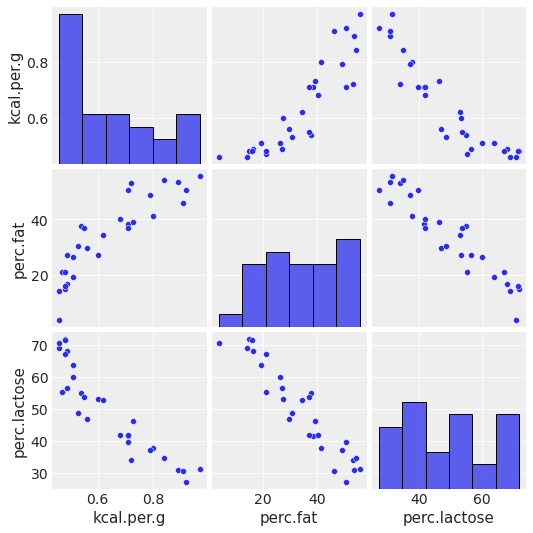

In [15]:
sns.pairplot(d.loc[:, ["kcal.per.g", "perc.fat", "perc.lactose"]]);

作者观点：**It is the conditional associations—not correlations—that matter. And even then, the right thing to do will depend upon what is causing the collinearity.**  

**因此作者提出了另一种因果假设**：在牛奶的例子中可能发生的事情是，在牛奶的成分中有一个核心的权衡，奶牛妈妈必须遵守。如果奶牛妈妈经常哺乳，那么产奶往往是水的和低能量的，这种奶富含糖（lactose）。如果奶牛妈妈很少在短时间内产奶，这种奶的脂肪（fat）含量很高。这意味着一个像这样的因果模型，中心权衡变量D决定了牛奶的密度。  但是D是无法观测到的变量。

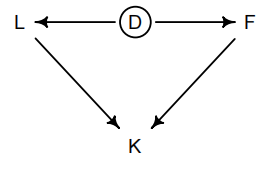

#### Code 6.12 Simulating collinearity

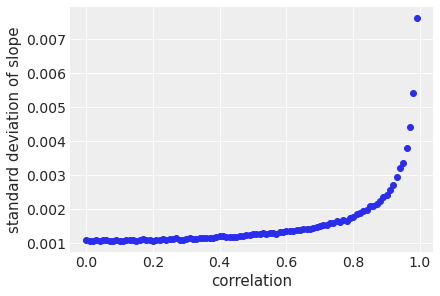

In [16]:
def mv(x, a, b, c):
    return a + x[0] * b + x[1] * c


def sim_coll(r=0.9):
    x = np.random.normal(loc=r * d["perc.fat"], scale=np.sqrt((1 - r**2) * np.var(d["perc.fat"])))
    _, cov = curve_fit(mv, (d["perc.fat"], x), d["kcal.per.g"])
    return np.sqrt(np.diag(cov))[-1]


def rep_sim_coll(r=0.9, n=100):
    return np.mean([sim_coll(r) for i in range(n)])


r_seq = np.arange(0, 1, 0.01)
stdev = list(map(rep_sim_coll, r_seq))

plt.scatter(r_seq, stdev)
plt.xlabel("correlation")
plt.ylabel("standard deviation of slope");

# 6.2 Post-treatment bias
It is routine to worry about mistaken inferences that arise from omitting predictor variables. Such mistakes are often called **omitted variable bias**, and the examples from the previous chapter illustrate it. It is much less routine to worry about mistaken inferences
arising from including variables. But **included variable bias** is real.

引起included variable bias的一个原因是post-treatment bias，后处理偏差。

参考网页：https://stats.stackexchange.com/questions/163174/why-is-post-treatment-bias-a-bias-and-not-just-multicollinearity#:~:text=Post-treatment%20bias%20occurs%20when%20the%20regression%20model%20includes,the%20consequence-of-treatment%20control%20variable%20is%20with%20the%20treatment.




#### Code 6.13 fungus为treatment的事后变量

In [17]:
# number of plants
N = 100
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

az.summary(d.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
h0,10.19,1.95,7.15,12.93
h1,14.28,2.41,10.78,18.26
treatment,0.50,0.50,0.00,1.00
fungus,0.31,0.46,0.00,1.00


## 6.2.1 A prior is born
该问题的模型如下：

\begin{array}{l}h_{1,i}\sim\operatorname{Normal}(\mu_i,\sigma)\\ \mu_i=h_{0,i}\times p \\ p\sim\operatorname{Log-Normal}(0,0.05) \\ \sigma\sim \operatorname{Exponential}(1)\end{array}

#### Code 6.14

In [18]:
sim_p = np.random.lognormal(0, 0.25, int(1e4))

az.summary(sim_p, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
x,1.03,0.26,0.64,1.42


#### Code 6.15

In [19]:
with pm.Model() as m_6_6:
    p = pm.Lognormal("p", 0, 0.25)

    mu = p * d.h0.values
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    m_6_6_trace = pm.sample()

az.summary(m_6_6_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,1.38,0.02,1.35,1.41,0.0,0.0,3501.56,2665.47,1.0
sigma,1.95,0.14,1.72,2.17,0.0,0.0,3713.12,2838.64,1.0


约有40%的身高增长，现将treatment和fungus变量加入模型： 

\begin{array}{l}h_{1,i}\sim\operatorname{Normal}(\mu_i,\sigma)\\ \mu_i=h_{0,i}\times p\\ p=\alpha+\beta_TT_i+\beta_FF_i\\ \alpha\sim\operatorname{Log-Normal}(0,0.25)\\ \beta_T\sim\operatorname{Normal}(0,0.5)\\ \beta_F\sim\operatorname{Normal}(0,0.5)\\ \sigma\sim\operatorname{Exponential}(1)\end{array}

#### Code 6.16

In [20]:
with pm.Model() as m_6_7:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)

    p = a + bt * d.treatment.values + bf * d.fungus.values

    mu = p * d.h0.values
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    m_6_7_trace = pm.sample()

az.summary(m_6_7_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bt, bf, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.45,0.02,1.42,1.49,0.0,0.0,2118.25,2088.24,1.0
bt,0.04,0.03,-0.01,0.08,0.0,0.0,2131.82,2532.23,1.0
bf,-0.27,0.03,-0.32,-0.23,0.0,0.0,2590.89,2529.88,1.0
sigma,1.30,0.10,1.16,1.46,0.0,0.0,2842.39,2315.96,1.0


a参数和之前的p相同，它们的后验几乎相同。**bt的边际后验（treatment effect）稳定为零，方差很小。说明treatment与生长无关。** 真菌似乎损害了植物的生长。但是我们创建数据时treatment分明发生了作用，后验为何说其与生长无关？

### 6.2.2 Blocked by consequence

The problem is that fungus is mostly a consequence of treatment. This is to say that fungus is a post-treatment variable. So when we control for fungus, the model is implicitly answering the question: **Once we already know whether or not a plant developed fungus, does soil treatment matter?** The answer is “no,” because soil treatment has its effects on growth through reducing fungus.  
  
  为了探索treatment对生长的影响，我们需要把post-treatment变量fungus删去。

#### Code 6.17

In [21]:
with pm.Model() as m_6_8:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)

    p = a + bt * d.treatment.values

    mu = p * d.h0.values
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    m_6_8_trace = pm.sample()

az.summary(m_6_8_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bt, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
The acceptance probability does not match the target. It is 0.8842, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.30,0.03,1.26,1.34,0.0,0.0,1124.23,2353.12,1.0
bt,0.14,0.04,0.09,0.20,0.0,0.0,1295.34,2269.93,1.0
sigma,1.86,0.14,1.65,2.10,0.0,0.0,2364.62,1632.56,1.0


### 6.2.3 Fungus and d-separation 从DAG的角度看待问题

#### Code 6.18

Using [`causalgraphicalmodels`](https://github.com/ijmbarr/causalgraphicalmodels) for graph drawing and analysis instead of `dagitty`, following the example of [ksachdeva's Tensorflow version of Rethinking](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

C:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


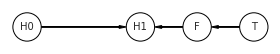

In [22]:
import daft

from causalgraphicalmodels import CausalGraphicalModel


def draw_dag(dag, coordinates):
    pgm = daft.PGM()
    for node in dag.dag.nodes:
        pgm.add_node(node, node, *coordinates[node])
    for edge in dag.dag.edges:
        pgm.add_edge(*edge)
    pgm.render()
    plt.gca().invert_yaxis()


plant_dag = CausalGraphicalModel(
    nodes=["H0", "H1", "F", "T"], edges=[("H0", "H1"), ("F", "H1"), ("T", "F")]
)
coordinates = {"H0": (0, 0), "T": (4, 0), "F": (3, 0), "H1": (2, 0)}

draw_dag(plant_dag, coordinates)

- 因此treatment T会影响fungus F的存在，F影响在时间1的株高H1。时间1的株高也受到时间0的株高H0的影响。当我们将变量F（post-treatment variable）放入回归模型时，在模型中，我们最终阻断了从T到H1的路径。即一旦我们知道了真菌F的状态，T就不会告诉我们任何结果。即残差之间的独立。    

- 用DAG的术语表达如下：  An even more DAG way to say this is that conditioning on F induces **d-separation.**  The “d” stands for directional. D-separation means that some variables on a directed graph are independent of others. There is no path connecting them. In this case, H1 is d-separated from T, but only when we condition on F. Conditioning on F effectively blocks the directed path T → F → H1, making T and H1 independent (d-separated). In the previous chapter, you saw the notation H1 ⊥⊥ T|F for this kind of statement, when we discussed implied conditional independencies.



接下来考虑另一种假设，读者可自行验证结果。

#### Code 6.19

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [23]:
all_independencies = plant_dag.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('H1', 'T', {'F'})
('T', 'H0', set())
('H0', 'F', set())


考虑下面的DAG图：  

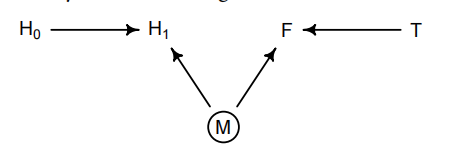  

假设某种生物的生长不受真菌的影响，同时存在一个尚未观察到的M变量同时影响真菌与生物的生长。H1对T的回归将显示T和植物生长之间没有关联。但如果我们在模型中加入F，突然间就会有一个关联。

#### Code 6.20 生成符合上述DAG图的数据

In [24]:
N = 1000
h0 = np.random.normal(10, 2, N)
treatment = np.repeat([0, 1], N / 2)
M = np.random.binomial(1, 0.5, size=N)  # assumed probability 0.5 here, as not given in book
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4 + 0.4 * M, size=N)
h1 = h0 + np.random.normal(5 + 3 * M, size=N)
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

az.summary(d.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
h0,10.14,2.01,6.92,13.37
h1,16.63,2.70,11.99,20.78
treatment,0.50,0.50,0.00,1.00
fungus,0.52,0.50,0.00,1.00


Re-run m_6_6 and m_6_7 on this dataset

# 6.3. Collider bias 对撞机偏差

引入：考虑新闻的可信性与其价值的模型，该模型认为可信性( T )和新闻性( N )在提交给评审小组的研究提案中不相关。但二者均影响筹资选择( S )，如图：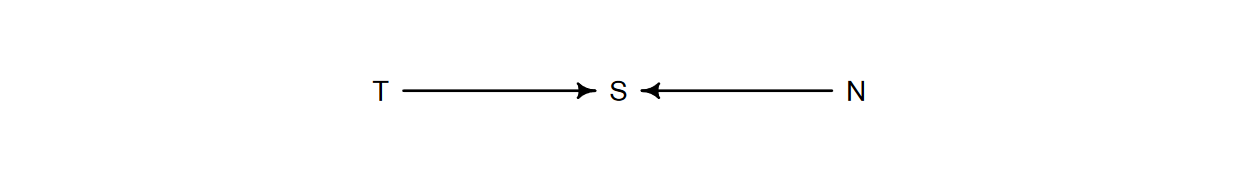

两个箭头进入S意味着它是一个对撞机。其核心理念很容易理解：当你在对撞机上条件时，它创造了统计上的因果关联（不一定是其原因有关）。在这种情况下，一旦你知道一个提案已经被选中( S )，那么知道它的可信度( T )也提供了关于它的新闻价值( N )的信息。
例如，如果一个选定的提案具有低可信度，那么它必须具有高新闻价值。否则就不会得到资助，反之同理。

- 考虑老龄化如何影响幸福感的问题

假设幸福感不因年龄而变化，由于越幸福的人，或年龄越大的人结婚的可能性更大，故以婚姻为对撞机
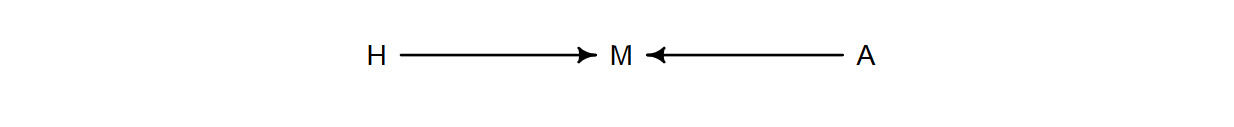

- 下面使用代码生成数据集

1.每年20人出生，幸福值服从均匀分布，且不随年龄增长而变化

2.个体达到18岁时可以结婚，每年结婚的几率与个人幸福值成正比

3.一旦结婚，个人变为已婚状态

4.65岁后个体移除样本

#### Code 6.21

In [25]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def sim_happiness(N_years=100, seed=1234):
    np.random.seed(seed)

    popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
    popn.loc[:, "age"] = np.repeat(np.arange(65), 20)
    popn.loc[:, "happiness"] = np.repeat(np.linspace(-2, 2, 20), 65)
    popn.loc[:, "married"] = np.array(popn.loc[:, "married"].values, dtype="bool")

    for i in range(N_years):
        # age population
        popn.loc[:, "age"] += 1
        # replace old folk with new folk
        ind = popn.age == 65
        popn.loc[ind, "age"] = 0
        popn.loc[ind, "married"] = False
        popn.loc[ind, "happiness"] = np.linspace(-2, 2, 20)

        # do the work
        elligible = (popn.married == 0) & (popn.age >= 18)
        marry = np.random.binomial(1, inv_logit(popn.loc[elligible, "happiness"] - 4)) == 1
        popn.loc[elligible, "married"] = marry

    popn.sort_values("age", inplace=True, ignore_index=True)

    return popn

In [26]:
popn = sim_happiness(N_years=1000, seed=1977) #运行1000年

popn_summ = popn.copy()
popn_summ["married"] = popn_summ["married"].astype(int)
# this is necessary before using az.summary, which doesn't work with boolean columns.
az.summary(popn_summ.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
age,32.00,18.77,0.0,57.00
happiness,-0.00,1.21,-2.0,1.58
married,0.28,0.45,0.0,1.00


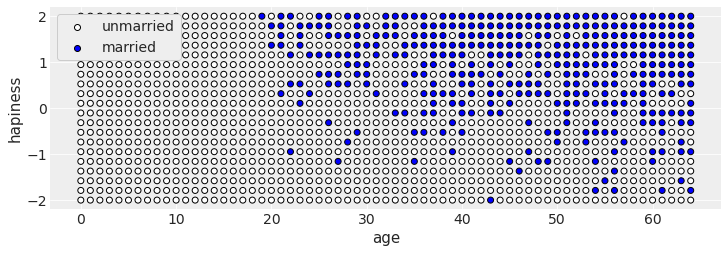

In [27]:
# Figure 6.4
fig, ax = plt.subplots(figsize=[10, 3.4])

colors = np.array(["w"] * popn.shape[0])
colors[popn.married] = "b"
ax.scatter(popn.age, popn.happiness, edgecolor="k", color=colors)

ax.scatter([], [], edgecolor="k", color="w", label="unmarried")
ax.scatter([], [], edgecolor="k", color="b", label="married")
ax.legend(loc="upper left", framealpha=1, frameon=True)

ax.set_xlabel("age")
ax.set_ylabel("hapiness");


若从以上数据中判断年龄是否与幸福感有关，有理由认为，婚姻状态可能是一个混淆变量。因此，我们考虑一个多元回归模型，旨在推断年龄对幸福感的影响，同时控制婚姻状况，线性模型如下所示，

其中MID[i]为个体i的婚姻状况指标，1表示单身，2表示已婚，A只考虑18岁以上的样本
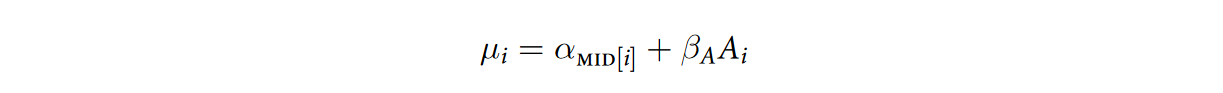

假设年龄与幸福感之间存在很强的关系，如在18岁时幸福值最高，65岁时最低，重新对年龄进行标注，使18-65为一个单位，即A的取值为0时是18岁，1时是65岁，幸福值的取值范围在-2到2之间，代码如下：

#### Code 6.22

In [28]:
adults = popn.loc[popn.age > 17].copy()
adults.loc[:, "A"] = (adults["age"].copy() - 18) / (65 - 18) 

#### Code 6.23

In [29]:
mid = adults.loc[:, "married"].astype(int).values

with pm.Model() as m_6_9:
    a = pm.Normal("a", 0, 1, shape=2)
    bA = pm.Normal("bA", 0, 2)

    mu = a[mid] + bA * adults.A.values
    sigma = pm.Exponential("sigma", 1)

    happiness = pm.Normal("happiness", mu, sigma, observed=adults.happiness.values)

    m_6_9_trace = pm.sample(1000)

az.summary(m_6_9_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.23,0.07,-0.33,-0.12,0.0,0.0,1772.33,2171.19,1.00
a[1],1.27,0.09,1.12,1.41,0.0,0.0,1970.61,2194.99,1.00
bA,-0.71,0.12,-0.89,-0.51,0.0,0.0,1671.24,1858.98,1.01
sigma,1.00,0.02,0.96,1.03,0.0,0.0,2268.29,2284.51,1.00


该模型非常肯定年龄与幸福感负相关，将这个模型的推论与一个忽略婚姻状况的模型进行比较，在这里是边缘后验分布

#### Code 6.24

In [30]:
with pm.Model() as m6_10:
    a = pm.Normal("a", 0, 1)
    bA = pm.Normal("bA", 0, 2)

    mu = a + bA * adults.A.values
    sigma = pm.Exponential("sigma", 1)

    happiness = pm.Normal("happiness", mu, sigma, observed=adults.happiness.values)

    trace_6_10 = pm.sample(1000)

az.summary(trace_6_10, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.6697, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8989, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8792, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.08,-0.13,0.12,0.0,0.0,1863.86,1889.94,1.0
bA,0.00,0.14,-0.21,0.23,0.0,0.0,1863.86,1871.54,1.0
sigma,1.22,0.03,1.17,1.26,0.0,0.0,2148.16,1567.94,1.0


相比之下，这个模型没有发现年龄和幸福感之间的联系，这正是我们期望的。

第一个模型中的对撞机是婚姻状况，是年龄和幸福的共同结果。因此，当我们对其进行条件化时，我们会在两个原因之间诱导出一个虚假的关联。从模型m6.9来看，年龄与幸福感负相关。但这只是一种统计关联，而非因果关联，一旦我们知道某人是否结婚，那么他们的年龄确实提供了关于他们有多幸福的信息

（返回看图：碰撞偏差，在已婚和未婚的子人群中，年龄与幸福感之间均存在负向关系，但并不能准确地反映因果关系）

正如前面的例子，对撞机偏差产生于对一个共同结果的条件化。但是要看到一个潜在的对撞机并不总是那么容易，因为可能它是无法测量的，这种不可测量的原因仍然可以诱发对撞机偏差。

例如，我们想推断父母( P )和祖父母( G )对子女教育成就( C )的直接影响
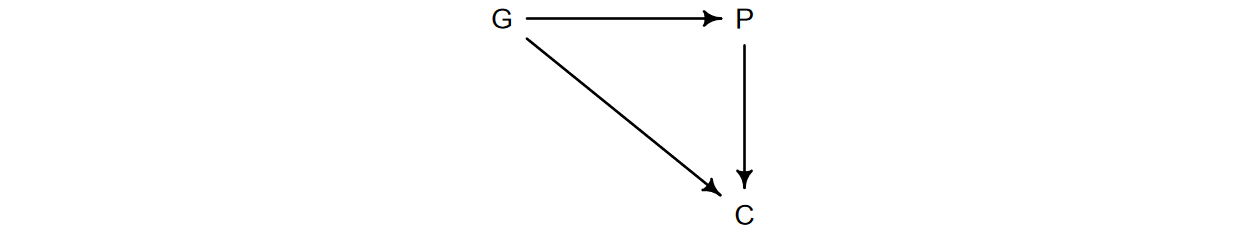

但假设存在不可测量的、共同的对父母及其子女的影响，比如邻里关系，这些影响不是由祖父母所共有的。然后我们的DAG被未被观测到的U所困扰：
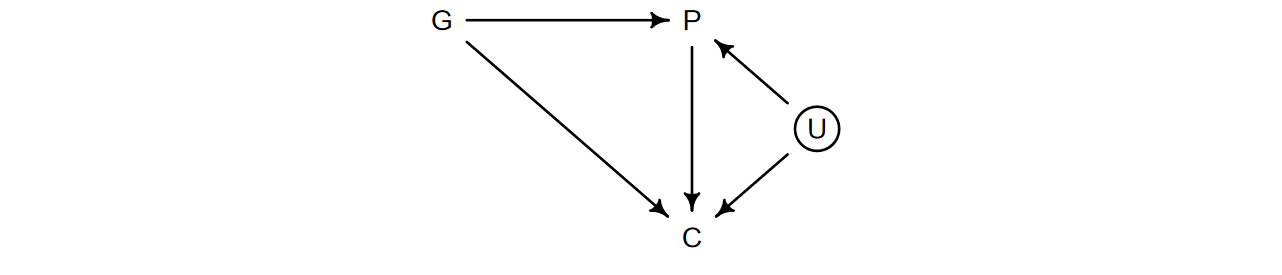

现在P是G和U的共同结果，所以如果我们对P进行条件化，就会对G→C的推论产生偏差，下面用代码实现：

(1) P是U、G的函数；(2)C是G，P，U的函数；(3)G和U不是任何其他已知变量的函数

#### Code 6.25

In [31]:
N = 200  # number of of grandparent-parent-child triads 200对样本
b_GP = 1  # direct effect of G on P
b_GC = 0  # direct effect of G on C 假设祖父母对子孙无直接影响
b_PC = 1  # direct effect of P on C
b_U = 2  # direct effect of U on P and C

#### Code 6.26

In [32]:
U = 2 * np.random.binomial(1, 0.5, N) - 1 ##二值化，取值为1或-1
G = np.random.normal(size=N)
P = np.random.normal(b_GP * G + b_U * U)
C = np.random.normal(b_PC * P + b_GC * G + b_U * U)
d = pd.DataFrame.from_dict({"C": C, "P": P, "G": G, "U": U})

In [32]:
U = 2 * np.random.binomial(1, 0.5, N) - 1
G = np.random.normal(size=N)
P = np.random.normal(b_GP * G + b_U * U)
C = np.random.normal(b_PC * P + b_GC * G + b_U * U)
d = pd.DataFrame.from_dict({"C": C, "P": P, "G": G, "U": U})

In [32]:
U = 2 * np.random.binomial(1, 0.5, N) - 1
G = np.random.normal(size=N)
P = np.random.normal(b_GP * G + b_U * U)
C = np.random.normal(b_PC * P + b_GC * G + b_U * U)
d = pd.DataFrame.from_dict({"C": C, "P": P, "G": G, "U": U})

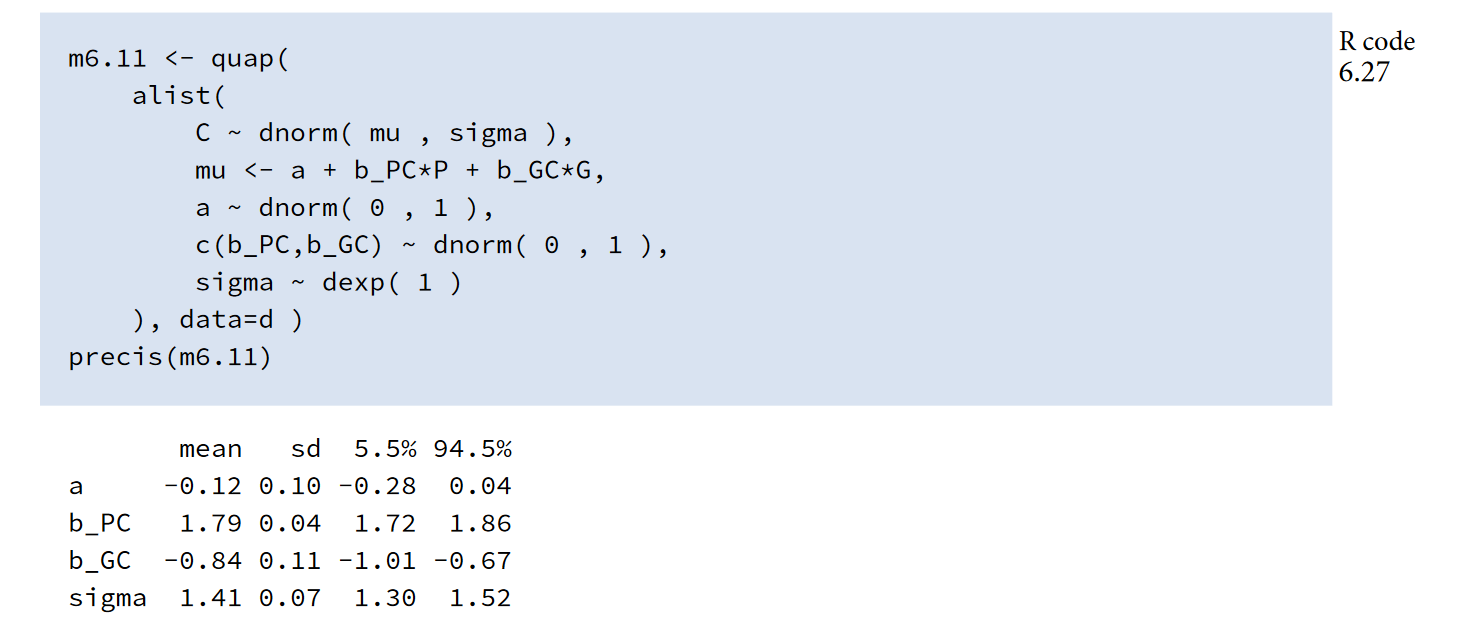

Text(0, 0.5, 'grandchild education (C)')

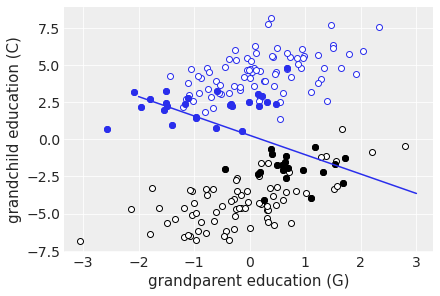

In [33]:
# Figure 6.5

# grandparent education
bad = U < 0
good = ~bad
plt.scatter(G[good], C[good], color="w", lw=1, edgecolor="C0")
plt.scatter(G[bad], C[bad], color="w", lw=1, edgecolor="k")

# parents with similar education
eP = (P > -1) & (P < 1)
plt.scatter(G[good & eP], C[good & eP], color="C0", lw=1, edgecolor="C0")
plt.scatter(G[bad & eP], C[bad & eP], color="k", lw=1, edgecolor="k")


p = np.polyfit(G[eP], C[eP], 1)
xn = np.array([-2, 3])
plt.plot(xn, np.polyval(p, xn))

plt.xlabel("grandparent education (G)")
plt.ylabel("grandchild education (C)")

蓝点云表示U=1，即好的邻里关系，黑点云表示U=-1，即不好的邻里关系，两个点云都显示G和C之间的正相关关系，更多受过教育的祖父母有更多受过教育的孙子女，这种影响完全通过父母产生。

将父母受教育程度在第45和第60百分位之间的填空点突出显示，通过这些点画一条回归线，将C对G回归，斜率为负。

之所以存在这种情况，是因为一旦知道了P，则知道G就在无形中告诉了我们关于邻域U的情况，而U与结果C相关联。考虑两个受教育程度相同的不同父母，比如中位数50百分位，其中一位父母有高学历的祖父母。另一方是受教育程度较低的祖父母。在这个例子中，这些父母拥有相同教育的唯一可能的方式是生活在不同类型的社区。我们看不到这些邻里效应，但邻里的影响仍然传递给了孩子C。所以对于选中的两个受教育程度相同的父母来说，高学历祖父母的父母最终会得到一个受教育程度较低的孩子。教育程度较低的祖父母的孩子最终会得到教育程度较高的孩子。

未测量的U使P成为对撞机，对P进行条件化产生对撞机偏差

#### Code 6.27

In [ ]:
with pm.Model() as m_6_11:
    a = pm.Normal("a", 0, 1)
    p_PC = pm.Normal("b_PC", 0, 1)
    p_GC = pm.Normal("b_GC", 0, 1)

    mu = a + p_PC * d.P.values + p_GC * d.G.values
    sigma = pm.Exponential("sigma", 1)

    pC = pm.Normal("C", mu, sigma, observed=d.C.values)

    m_6_11_trace = pm.sample()

az.summary(m_6_11_trace, round_to=2)

#### Code 6.28

In [ ]:
with pm.Model() as m_6_12:
    a = pm.Normal("a", 0, 1)
    p_PC = pm.Normal("b_PC", 0, 1)
    p_GC = pm.Normal("b_GC", 0, 1)
    p_U = pm.Normal("b_U", 0, 1)

    mu = a + p_PC * d.P.values + p_GC * d.G.values + p_U * d.U.values
    sigma = pm.Exponential("sigma", 1)

    pC = pm.Normal("C", mu, sigma, observed=d.C.values)

    m_6_12_trace = pm.sample()

az.summary(m_6_12_trace, round_to=2)

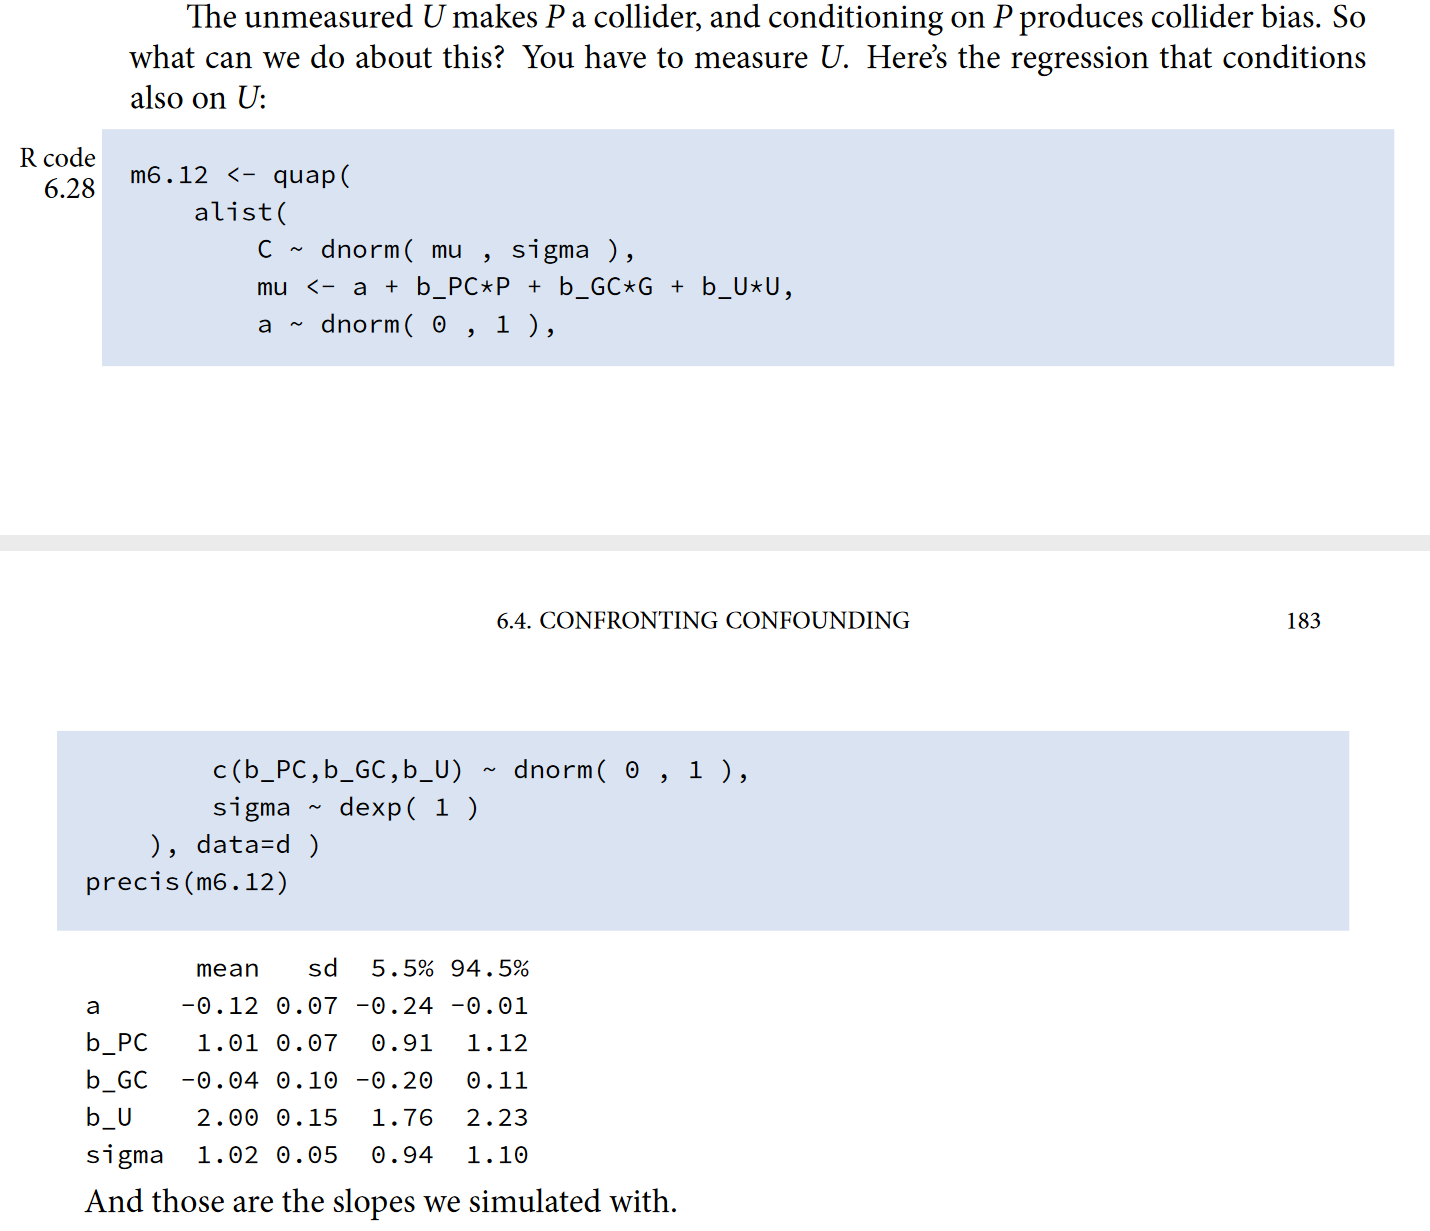

#### Code 6.29

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [ ]:
dag_6_1 = CausalGraphicalModel(
    nodes=["X", "Y", "C", "U", "B", "A"],
    edges=[
        ("X", "Y"),
        ("U", "X"),
        ("A", "U"),
        ("A", "C"),
        ("C", "Y"),
        ("U", "B"),
        ("C", "B"),
    ],
)
all_adjustment_sets = dag_6_1.get_all_backdoor_adjustment_sets("X", "Y")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        if s != {"U"}:
            print(s)

#### Code 6.30

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [ ]:
dag_6_2 = CausalGraphicalModel(
    nodes=["S", "A", "D", "M", "W"],
    edges=[
        ("S", "A"),
        ("A", "D"),
        ("S", "M"),
        ("M", "D"),
        ("S", "W"),
        ("W", "D"),
        ("A", "M"),
    ],
)
all_adjustment_sets = dag_6_2.get_all_backdoor_adjustment_sets("W", "D")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        print(s)

#### Code 6.31

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [ ]:
all_independencies = dag_6_2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

## 6.4识别混淆变量

假设我们对教育E和工资W之间的关系感兴趣，U为一些未观测的变量同时影响E和W，DAG如左图，连接E和W的路径有两条：(1) E→W和(2) E←U→W，路径2为后门路径；将其阻断有两种方法，人为控制E或加入条件U，则DAG变为右图，只剩下一条因果路径

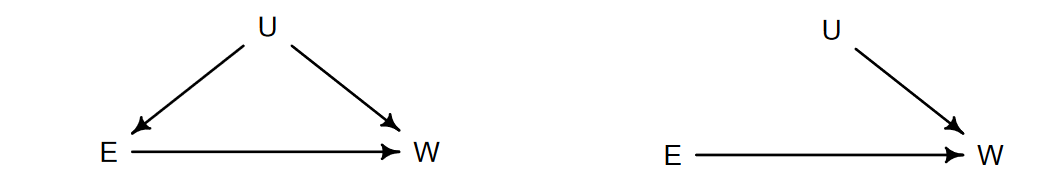

无论因果DAG看起来多么复杂，它总是建立以下这四种关系

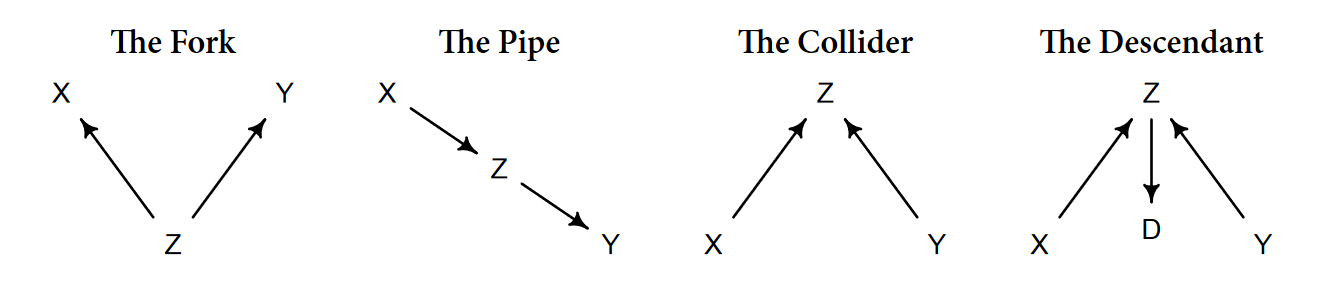

（1）X和Y是独立的，以Z为条件，那么了解X也不会告诉我们Y；

（2）我们在讨论植物生长实例和后处理偏差时看到了这一点：处理X影响真菌Z从而影响生长Y。如果我们对Z进行条件，也阻断了从X到Y的路径；

（3）在对撞机中，X和Y之间没有关联，而当以Z为条件时，对撞机变量打开路径，两者产生统计关联，但X和Y对另一方没有任何因果影响；

（4）D是Z的子代，对D的条件化也会在较小的程度上对Z进行条件化，原因是D有关于Z的一些信息。在这个例子中，这会部分打开X到Y的路径，因为Z是一个对撞机。但一般而言，条件化对后代的影响取决于其父代的性质。子代是常见的，因为我们往往不能直接测量一个变量，而只能用一些代理变量。

前两者控制变量会阻断路径，后两者控制变量会打开路径

实际操作步骤：

(1)列出连接X (潜在的兴趣原因)和Y的所有路径(结果)；

(2)对每条路径按照是否开放或封闭进行分类；

(3)根据每条路径是否为后门路径进行分类（后门路径有一个箭头进入X）；

(4)如果有任何打开的后门路径，决定使用哪个变量来关闭它(如果可能的话)。

例1：包含自变量X、因变量Y、未观测到的变量U和三个观测到的协变量(A、B、C)
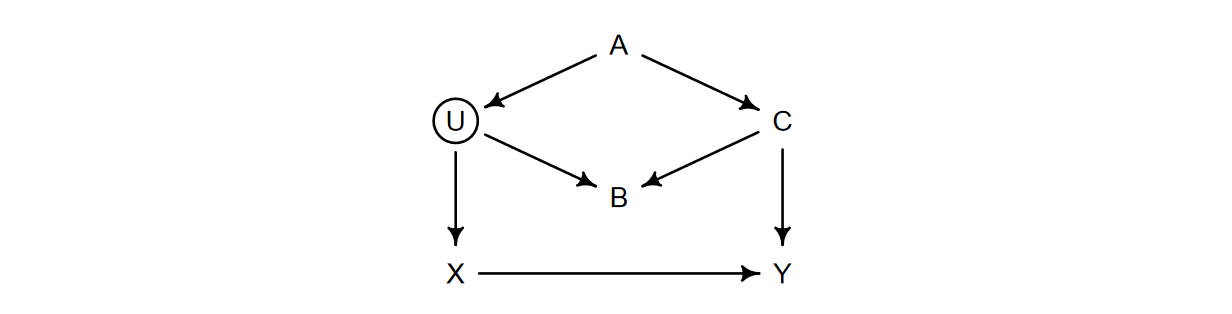

除了最直接的路径，还有两条路径连接X和Y

(1) X ← U ← A → C → Y（后门路径，对应类型1、2，已开放，处理方式：条件化A或C）

(2) X ← U → B ← C → Y（后门路径，对应类型3，已关闭，处理方式；不要条件化B）

例2：第五章华夫饼与离婚率案例
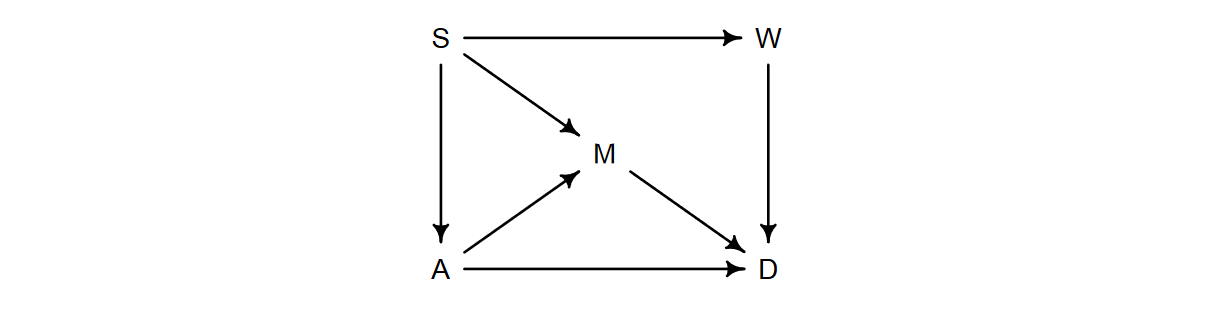

S为是否在美国南部，A为结婚年龄中位数，M为结婚率，W为华夫饼屋数量，D为离婚率。除了最直接的路径，还有三条路径经过S来连接W和D，可以通过条件化S来处理。但这个图中没有未观测到的变量，这显然是不合理的。可以通过条件独立来检验DAG图的特征（代码）。

### 总结：利用好DAG，合理应对多元回归中的各种偏差